Department of Physics, University of Pisa (AA 20202-2023)

### Multimessenger Physics Laboratory



## Data Analysis experience - Gravitational Waves 
#### (M. Razzano, Apr 26,2023)

This notebook serves as outline for the data analysis experience of gravitational wave events from coalescing systems. You can see more details on the various commands in the tutorial stored in the tutorials directory.

**Do not forget** to add the extra files that you might use for the analysis, e.g. the data files to this Github repository in the data directory

More details are contained in the PDF file containing the description of this experience, that is available on Moodle (e-learning)

### Basic Setup
First of all, we import the required modules and we download the data file.

In [27]:
import os   #These two are useful modules
import sys

#here you can import other useful modules, such as numpy, matplotlib, etc..
import numpy as np #Numerical Python
import matplotlib.pyplot as plt
from scipy import optimize

#also import astropy.fits
from astropy.io import fits
from gwosc.datasets import find_datasets
from gwosc.datasets import event_gps
from gwosc.locate import get_event_urls
from gwpy.timeseries import TimeSeries
from gwpy.segments import DataQualityFlag
from gwpy.plot import Plot
from scipy.signal import get_window
from gwpy.plot.colors import GW_OBSERVATORY_COLORS


import pylab
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import get_td_waveform
from pycbc.filter import matched_filter
from pycbc.waveform import get_td_waveform

**Important** Within the notebook you can run BASH command, by putting a ! before the command. For instance, if you want to run a ls command, type !ls

# Let's set some useful variables
The data are stored in a "data" directory at the same level of the "code" directory where you are now. Let's do some work to navigate the directory...
We will use the *os* module, in particular the *os.path* submodule.

**Note**: In this case we define the directories directly in this notebook, instead of using environment variables. For this examples, it is easier...

In [23]:
# Let's define te directory where you are with the "get current working directory" command...
work_dir = os.getcwd()
print("I am in dir %s" % work_dir)

#We can go up by using the path.dirname
main_dir =os.path.dirname(work_dir)
print("Main directory is %s" % main_dir)

#We can then define the data directory using the os.path.join command
data_dir = os.path.join(main_dir,"data")
print("Data directory is %s" % data_dir)

#..and we can define some output directory with the results
results_dir = os.path.join(main_dir,"results")

#if the directory does not exist, you can create it...
if not os.path.exists(results_dir):
    os.mkdir(results_dir)
    print("Directory %s created!" % results_dir)
else:
    print("Results directory is %s" % data_dir)
    

I am in dir /home/jovyan/experience-gw-data-analysis-chiaramasia01/code
Main directory is /home/jovyan/experience-gw-data-analysis-chiaramasia01
Data directory is /home/jovyan/experience-gw-data-analysis-chiaramasia01/data
Results directory is /home/jovyan/experience-gw-data-analysis-chiaramasia01/data


# Let's get started
After this basic setup, you are ready to start with the analysis. Enjoy!

# Explore the GWOSC event data set

In [24]:
events = find_datasets(type="event") # access to events
ev_name = 'GW170809' # selecting event

''' Questo evento ha interessato H1, L1 e V1 '''
detectors = ['H1', 'L1', 'V1']
ev_ifo = detectors[0] # selecting desired detector, starting from the first

ev_gps = event_gps(ev_name) # fetch data for time series ; ok matches with t0 in guidelines file
event_urls = get_event_urls(ev_name) # accessing data urls

print("%s,%.1f,%s" % (ev_name,ev_gps,event_urls))

GW170809,1186302519.8,['http://gwosc.org/eventapi/json/GWTC-1-confident/GW170809/v1/H-H1_GWOSC_4KHZ_R1-1186302504-32.hdf5', 'http://gwosc.org/eventapi/json/GWTC-1-confident/GW170809/v1/H-H1_GWOSC_4KHZ_R1-1186300472-4096.hdf5', 'http://gwosc.org/eventapi/json/GWTC-1-confident/GW170809/v1/L-L1_GWOSC_4KHZ_R1-1186302504-32.hdf5', 'http://gwosc.org/eventapi/json/GWTC-1-confident/GW170809/v1/L-L1_GWOSC_4KHZ_R1-1186300472-4096.hdf5', 'http://gwosc.org/eventapi/json/GWTC-1-confident/GW170809/v1/V-V1_GWOSC_4KHZ_R1-1186302504-32.hdf5', 'http://gwosc.org/eventapi/json/GWTC-1-confident/GW170809/v1/V-V1_GWOSC_4KHZ_R1-1186300472-4096.hdf5']


# Some basic operations on signal processing
Here we will select a time frame and see how we can have a quick look at the signal and do some basic filtering

### The DataQualityFlag class
A DataQualityFlag is an annotated set of segments that indicate something about instrumental operation. Each flag is defined by applying some algorithm on data and generating a SegmentList that indicates some good or bad condition has been met during those times. For example, the times during which the LIGO interferometers are operating under observing conditions are recorded as the ‘analysis-ready’ flag, which is used by data analysis groups to define periods of data over which to search for gravitational-wave signals. Conversely, high seismic noise around the observatory buildings is recorded in a data-quality flag used by those groups to veto periods of analysis as a result of sub-standard data.

A window function, in this context, is a mathematical function that is multiplied with a signal in the time domain before performing a Fourier transform (or other spectral analysis). This multiplication helps reduce spectral leakage and artifacts that can occur when analyzing a finite segment of a signal.

The Hann window is defined as 
𝑤(𝑛)=0.5−0.5⋅cos⁡(2𝜋𝑛/𝑁−1)
where 𝑁 is the length of the window and 
n is the sample index ranging from 0 to 
𝑁−1 . It tapers the signal smoothly toward zero at its edges.

### Detector H1

/opt/conda/lib/python3.8/site-packages/gwpy/types/series.py:924: UserWarning: TimeSeries.crop given end larger than current end, crop will end when the Series actually ends.
  warn('%s.crop given end larger than current end, '


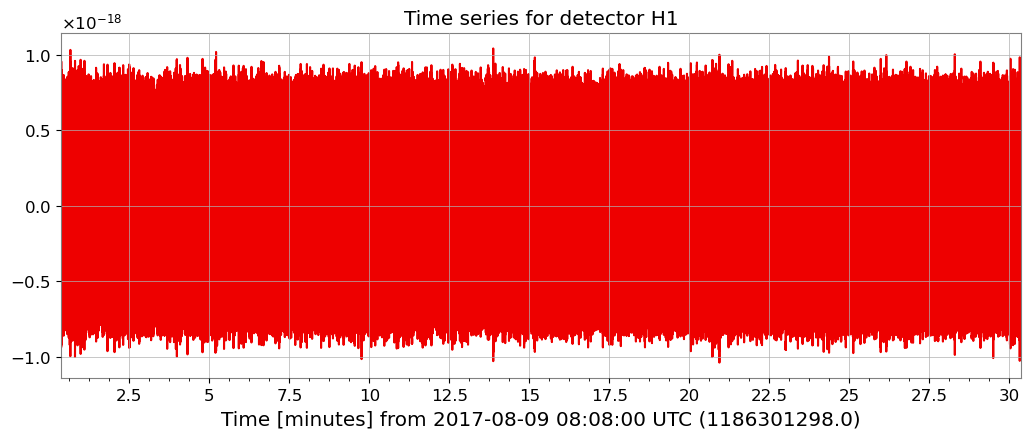

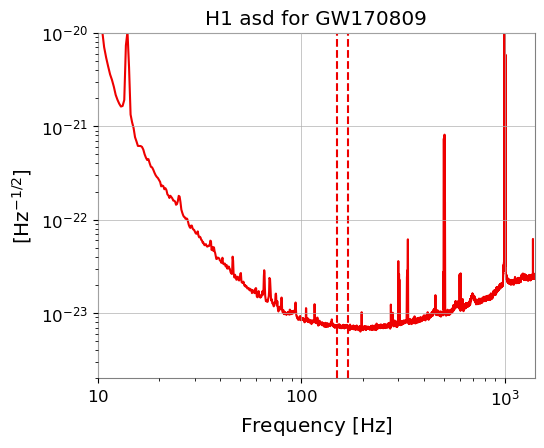

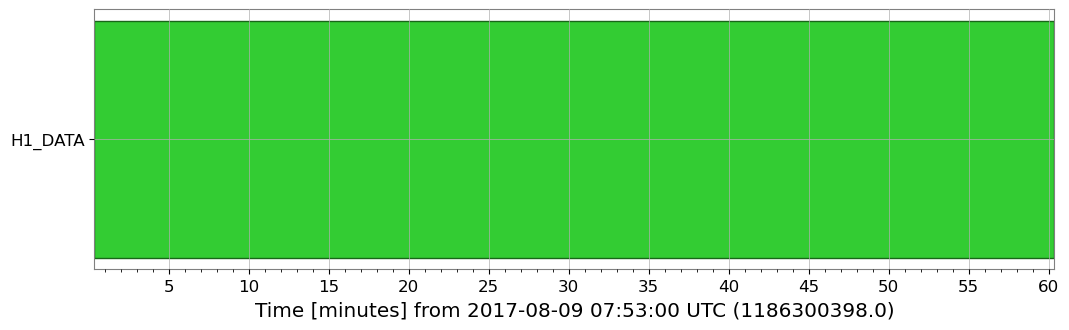

In [4]:
''' GWpy’s TimeSeries class provides an interface to the public GWOSC data 
in the fetch_open_data() method; to use it we need to first import the TimeSeries object: '''


# Select a time interval of 30 mins around the event. This is because on GWOSC there is 1 hour data window released around events
dt_win=3600*0.25
ev_t0_min = ev_gps-60*20 # 20 mins before event
ev_t0_max = ev_gps+60*10 # 10 mins after event

# range of frequences chosen
f_start=[150, 100, 105]
f_stop=[170, 120, 125]

start_asd=[]
stop_asd=[]

# DETECTOR H1

ev_ifo = 'H1' 
ev_gps = event_gps(ev_name)
data_H1 = TimeSeries.fetch_open_data(ev_ifo,ev_t0_min,ev_t0_max,cache=True)
plot_data=Plot(data_H1, color=GW_OBSERVATORY_COLORS['H1'], figsize=(12, 4.8), title='Time series for detector H1', separate=True)
fft_data_H1 = data_H1.fft()
window = get_window('hann', data_H1.size)
hwin = data_H1 * window

fftamp = hwin.fft().abs()

asd_H1 = data_H1.asd(fftlength=4, method="median")
plot = asd_H1.plot(color=GW_OBSERVATORY_COLORS['H1'])
ax = plot.gca()
ax.set_xlim(10, 1400)
ax.set_ylim(2e-24, 1e-20)
ax.set_title(ev_ifo+ " asd for "+ev_name)

# selecting a range where the detector is most sensitive
ax.axvline(f_start[0], linestyle='--', color=GW_OBSERVATORY_COLORS['H1']) # start of selected range
ax.axvline(f_stop[0], linestyle='--', color=GW_OBSERVATORY_COLORS['H1']) # end of selected range
line = ax.lines[0] # accessing the frequencies
x_data = np.array(line.get_xdata())
cond1 = np.where(x_data == f_start[0])[0] # finding the starting index of frequency range
start_asd.append(cond1[0])
cond2 = np.where(x_data == f_stop[0])[0]
stop_asd.append(cond2[0]) # finding the ending index of frequency range

# verifying that the event occurred in a valid segment (green)
segments_H1 = DataQualityFlag.fetch_open_data(ev_ifo+"_DATA",ev_t0_min-dt_win,ev_t0_max+dt_win)
plot = segments_H1.plot()

plot.refresh()
plot.show()

### Detector L1

/opt/conda/lib/python3.8/site-packages/gwpy/types/series.py:924: UserWarning: TimeSeries.crop given end larger than current end, crop will end when the Series actually ends.
  warn('%s.crop given end larger than current end, '


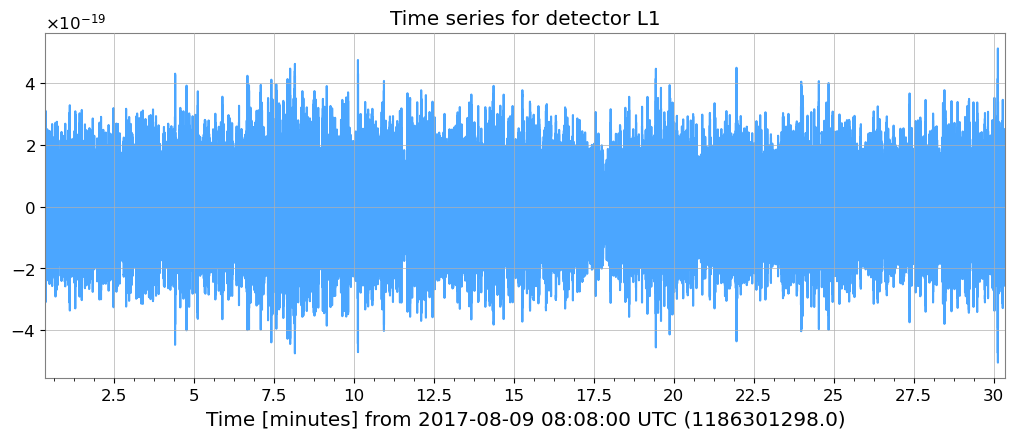

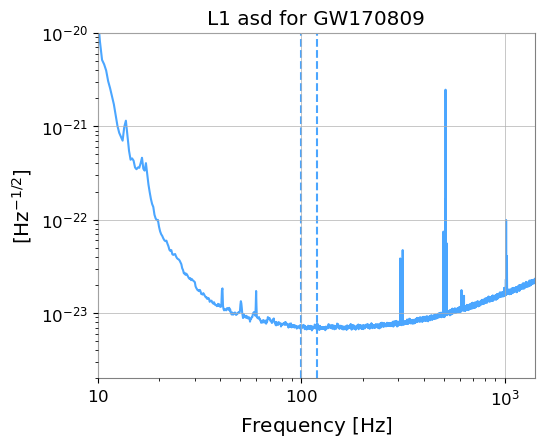

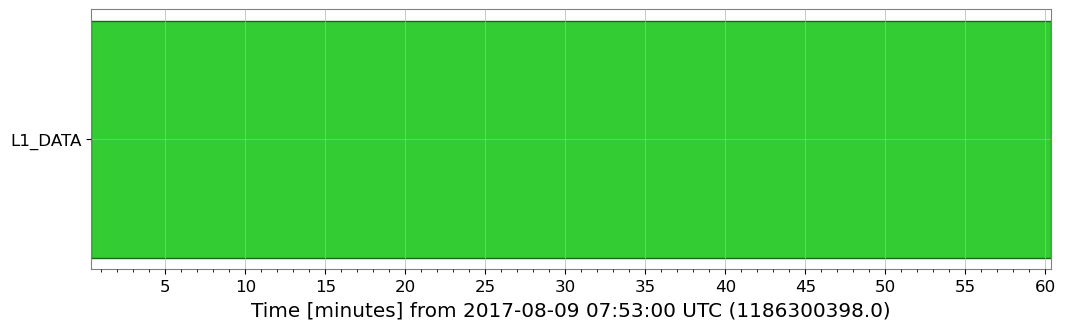

In [5]:
# DETECTOR L1

ev_ifo = 'L1' 
ev_gps = event_gps(ev_name)
data_L1 = TimeSeries.fetch_open_data(ev_ifo,ev_t0_min,ev_t0_max,cache=True)
plot_data=Plot(data_L1, color=GW_OBSERVATORY_COLORS['L1'], figsize=(12, 4.8), title='Time series for detector L1', separate=True)
fft_data_L1 = data_L1.fft()
window = get_window('hann', data_L1.size)
hwin = data_L1 * window

fftamp = hwin.fft().abs()

asd_L1 = data_L1.asd(fftlength=4, method="median")
plot = asd_L1.plot(color=GW_OBSERVATORY_COLORS['L1'])
ax = plot.gca()
ax.set_xlim(10, 1400)
ax.set_ylim(2e-24, 1e-20)
ax.set_title(ev_ifo+ " asd for "+ev_name)

# selecting a range where the detector is most sensitive
ax.axvline(f_start[1], linestyle='--', color=GW_OBSERVATORY_COLORS['L1']) # start of selected range
ax.axvline(f_stop[1], linestyle='--', color=GW_OBSERVATORY_COLORS['L1']) # end of selected range
line = ax.lines[0] # accessing the frequencies
x_data = np.array(line.get_xdata())
cond1 = np.where(x_data == f_start[1])[0] # finding the starting index of frequency range
start_asd.append(cond1[0])
cond2 = np.where(x_data == f_stop[1])[0]
stop_asd.append(cond2[0]) # finding the ending index of frequency range

# verifying that the event occurred in a valid segment (green)
segments_L1 = DataQualityFlag.fetch_open_data(ev_ifo+"_DATA",ev_t0_min-dt_win,ev_t0_max+dt_win)
plot = segments_L1.plot()

plot.refresh()
plot.show()

### Detector V1

/opt/conda/lib/python3.8/site-packages/gwpy/types/series.py:924: UserWarning: TimeSeries.crop given end larger than current end, crop will end when the Series actually ends.
  warn('%s.crop given end larger than current end, '


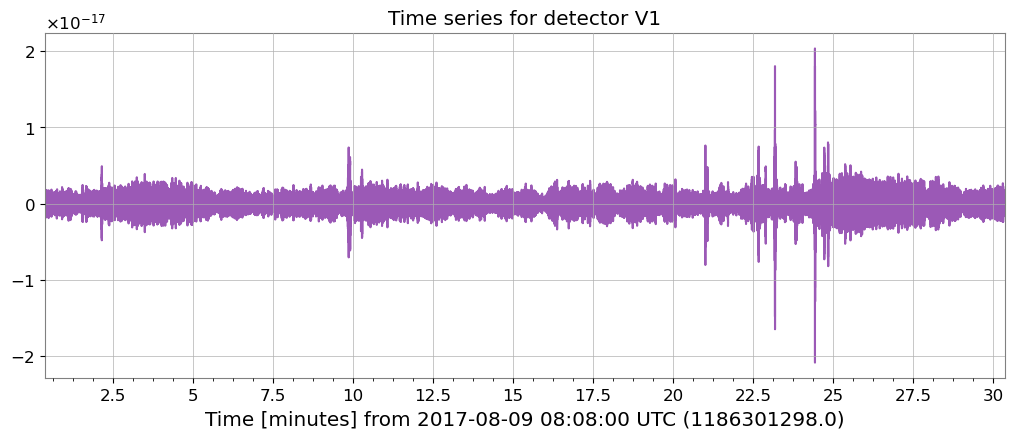

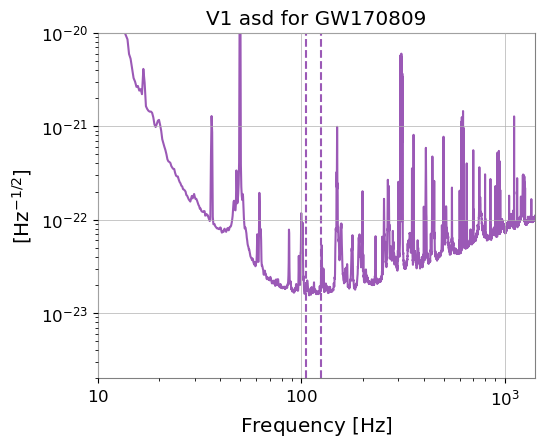

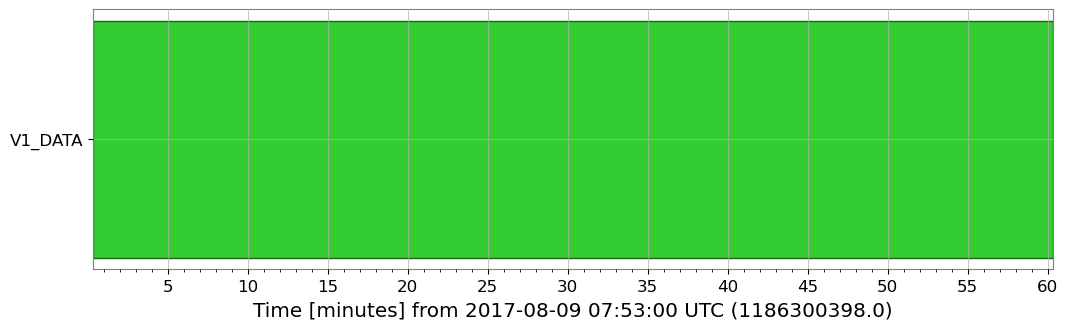

In [6]:
# DETECTOR V1

ev_ifo = 'V1' 
ev_gps = event_gps(ev_name)
data_V1 = TimeSeries.fetch_open_data(ev_ifo,ev_t0_min,ev_t0_max,cache=True)
plot_data=Plot(data_V1, color=GW_OBSERVATORY_COLORS['V1'], figsize=(12, 4.8), title='Time series for detector V1', separate=True)
fft_data_V1 = data_V1.fft()
window = get_window('hann', data_V1.size)
hwin = data_V1 * window

fftamp = hwin.fft().abs()

asd_V1 = data_V1.asd(fftlength=4, method="median")
plot = asd_V1.plot(color=GW_OBSERVATORY_COLORS['V1'])
ax = plot.gca()
ax.set_xlim(10, 1400)
ax.set_ylim(2e-24, 1e-20)
ax.set_title(ev_ifo+ " asd for "+ev_name)

# selecting a range where the detector is most sensitive
ax.axvline(f_start[2], linestyle='--', color=GW_OBSERVATORY_COLORS['V1']) # start of selected range
ax.axvline(f_stop[2], linestyle='--', color=GW_OBSERVATORY_COLORS['V1']) # end of selected range
line = ax.lines[0] # accessing the frequencies
x_data = np.array(line.get_xdata())
cond1 = np.where(x_data == f_start[2])[0] # finding the starting index of frequency range
start_asd.append(cond1[0])
cond2 = np.where(x_data == f_stop[2])[0]
stop_asd.append(cond2[0]) # finding the ending index of frequency range

# verifying that the event occurred in a valid segment (green)
segments_V1 = DataQualityFlag.fetch_open_data(ev_ifo+"_DATA",ev_t0_min-dt_win,ev_t0_max+dt_win)
plot = segments_V1.plot()

plot.refresh()
plot.show()

## Plot the the three asd together

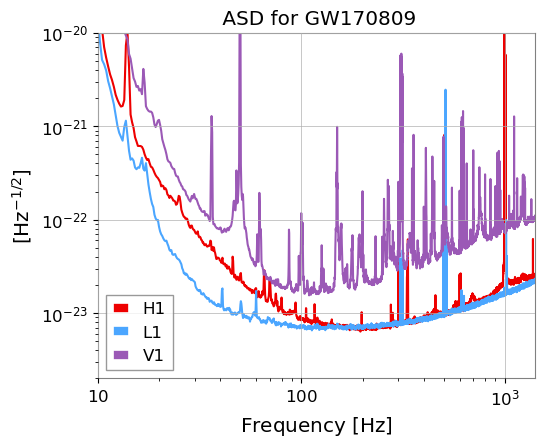

In [7]:

plot = asd_H1.plot(color=GW_OBSERVATORY_COLORS['H1'], label='H1')
ax = plot.gca()
ax.plot(asd_L1, color=GW_OBSERVATORY_COLORS['L1'], label='L1')
ax.plot(asd_V1, color=GW_OBSERVATORY_COLORS['V1'], label='V1')
ax.set_xlim(10, 1400)
ax.set_ylim(2e-24, 1e-20)
ax.set_title(" ASD for "+ev_name)
ax.legend()
plot.show()
my_file='asd.pdf'
plot.savefig(os.path.join(results_dir, my_file))

### Noise characterization H1

In [25]:
ev_t0_min = ev_gps-60*20 # 20 mins before event
ev_t0_max = ev_gps+60*10 # 10 mins after event
ev_ifo = 'H1'
ev_gps = event_gps(ev_name)
ev_t0_min = ev_gps-60*20 # 20 mins before event
ev_t0_max = ev_gps+60*10 # 10 mins after event
#data = TimeSeries.fetch_open_data(ev_ifo,ev_t0_min,ev_t0_max,cache=True)
#plot_data=Plot(data, color=colors[index], figsize=(12, 4.8), title='Time series for detector %s' % ii, separate=True)
time_range = np.arange(ev_t0_min, ev_t0_max, 20) # start, stop, step

mean_asd_H1 = [] # creating array for asd mean 
std_asd_H1 = [] # creating array for asd std

for ii in range(len(time_range)-1): # falli a blocchi di 5 se no esplode
    data = TimeSeries.fetch_open_data(ev_ifo, time_range[ii] , time_range[ii+1] ,cache=True) # time range
    #plot_data=Plot(data, figsize=(12, 4.8), title='Time series for detector H1', color=GW_OBSERVATORY_COLORS['H1']) # plot time series
    fft_data = data.fft() # compute fft
    window = get_window('hann', data[ii:ii+1].size)
    hwin = data * window
    fftamp = hwin.fft().abs()
    
    
    asd = data.asd(fftlength=4, method="median") # plot asd
    #plot = asd.plot(color=GW_OBSERVATORY_COLORS['H1'])
    #ax = plot.gca()
    #ax.set_xlim(10, 1400)
    #ax.set_ylim(2e-24, 1e-20)
    #ax.set_title(ev_ifo+ " asd for "+ev_name)
    #ax.axvline(f_start[0], linestyle='--', color=GW_OBSERVATORY_COLORS['H1'])
    #ax.axvline(f_stop[0], linestyle='--', color=GW_OBSERVATORY_COLORS['H1'])
    mean = np.mean(asd[start_asd[0]:stop_asd[0]])
    mean_asd_H1.append(mean.value) # .value function returns only the number without the unit
    std = np.std(asd[start_asd[0]:stop_asd[0]])
    std_asd_H1.append(std.value)
    #print('calculating %d' %ii)

    #plot.refresh
print('Done')
plot.show()
#print(mean_asd_H1)
#print(std_asd_H1)



/opt/conda/lib/python3.8/site-packages/gwpy/types/series.py:924: UserWarning: TimeSeries.crop given end larger than current end, crop will end when the Series actually ends.
  warn('%s.crop given end larger than current end, '


Done


m = 5.084897320653278e-28 +/- 6.687765895336092e-27
q = 6.979474965743676e-24 +/- 3.4495418460441615e-25
Reduced chi^2 = 0.02373423182827492


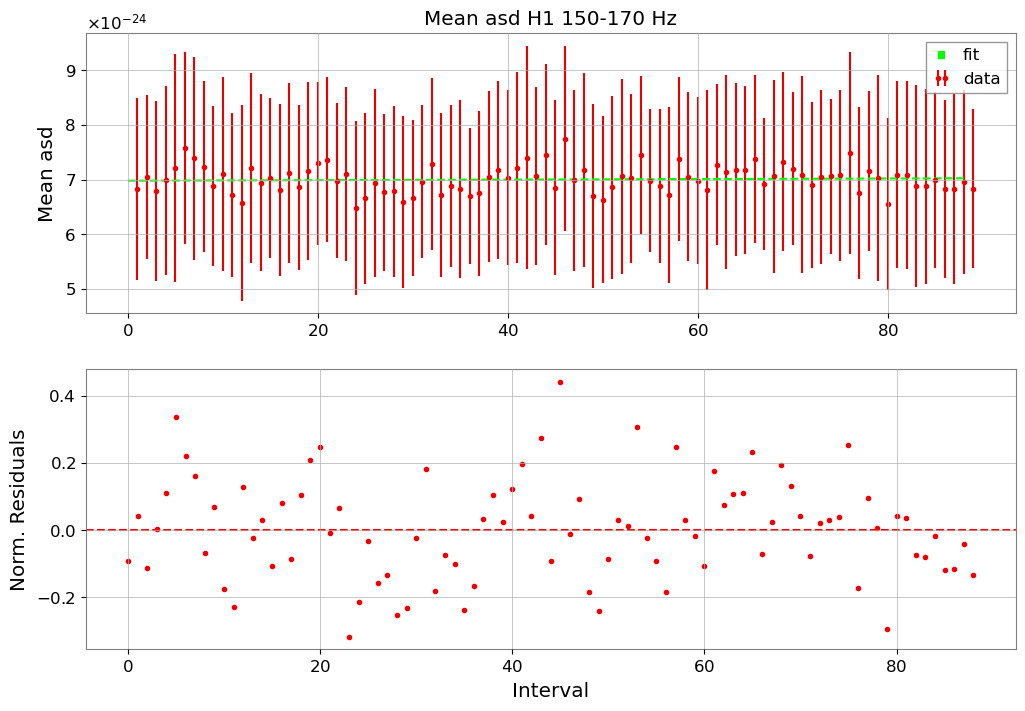

In [49]:
'''mean_plot = Plot(mean_asd_H1, figsize=(12, 4.8), title='ASD mean for detector H1', color=GW_OBSERVATORY_COLORS['H1'])
ax = mean_plot.gca()
ax.set_xlabel('Number of interval selected')
ax.set_ylabel('Mean value [Hz^-1/2]')

std_plot = Plot(std_asd_H1, figsize=(12, 4.8), title='ASD std for detector H1', color=GW_OBSERVATORY_COLORS['H1'])
ax = std_plot.gca()
ax.set_xlabel('Number of interval selected')
ax.set_ylabel('Std value [Hz^-1/2]')'''

# funzione di fit
def line(x, m, q):
    return m*x + q

# fit
guess = [0, np.mean(mean_asd_H1)]
xarray = np.linspace(1, len(mean_asd_H1), len(mean_asd_H1))

popt, pcov = optimize.curve_fit(line, xarray, mean_asd_H1, sigma=std_asd_H1, p0=guess , absolute_sigma=True)
print("m =", popt[0], "+/-", pcov[0,0]**0.5)
print("q =", popt[1], "+/-", pcov[1,1]**0.5)

plot=plt.figure(figsize=(12, 8))
plt.subplot(2,1,1)
plt.errorbar(xarray, mean_asd_H1, yerr=std_asd_H1, fmt='.', color=GW_OBSERVATORY_COLORS['H1'], label='data')
plt.title('Mean asd H1 150-170 Hz')
plt.ylabel('Mean asd')
plt.plot(xdata, line(xarray, popt[0], popt[1]), color='#00FF00', linestyle='--', label='fit')
plt.legend()

#compute residuals
residuals = (mean_asd_H1 - line(xarray, popt[0], popt[1]))/std_asd_H1

#plot
plt.subplot(2,1,2)
plt.plot(xdata, residuals, '.', color=GW_OBSERVATORY_COLORS['H1'])
plt.xlabel("Interval")
plt.ylabel("Norm. Residuals")

#draw line around zero
plt.axhline(0, color="r", linestyle='--')

# chi squared
chisqr = sum((mean_asd_H1 - line(xarray, popt[0], popt[1]))**2 / np.array(std_asd_H1)**2)
dof = len(mean_asd_H1) - len(popt)
chisqr_red = chisqr/dof
print(f'Reduced chi^2 = {chisqr_red}')

# save figure
my_file= 'asdmean_H1.pdf'
plot.savefig(os.path.join(results_dir, my_file))

### Noise characterization L1

In [56]:
ev_t0_min = ev_gps-60*20 # 20 mins before event
ev_t0_max = ev_gps+60*10 # 10 mins after event
ev_ifo = 'L1'
ev_gps = event_gps(ev_name)
ev_t0_min = ev_gps-60*20 # 20 mins before event
ev_t0_max = ev_gps+60*10 # 10 mins after event
#data = TimeSeries.fetch_open_data(ev_ifo,ev_t0_min,ev_t0_max,cache=True)
#plot_data=Plot(data, color=colors[index], figsize=(12, 4.8), title='Time series for detector %s' % ii, separate=True)
time_range = np.arange(ev_t0_min, ev_t0_max, 20) # start, stop, step

mean_asd_L1 = [] # creating array for asd mean 
std_asd_L1 = [] # creating array for asd std

for ii in range(len(time_range)-1): # falli a blocchi di 5 se no esplode
    data = TimeSeries.fetch_open_data(ev_ifo, time_range[ii] , time_range[ii+1] ,cache=True) # time range
    #plot_data=Plot(data, figsize=(12, 4.8), title='Time series for detector L1', color=GW_OBSERVATORY_COLORS['L1']) # plot time series
    fft_data = data.fft() # compute fft
    window = get_window('hann', data[ii:ii+1].size)
    hwin = data * window
    fftamp = hwin.fft().abs()
    
    
    asd = data.asd(fftlength=4, method="median") # plot asd
    #plot = asd.plot(color=GW_OBSERVATORY_COLORS['L1'])
    #ax = plot.gca()
    #ax.set_xlim(10, 1400)
    #ax.set_ylim(2e-24, 1e-20)
    #ax.set_title(ev_ifo+ " asd for "+ev_name)
    #ax.axvline(f_start[0], linestyle='--', color=GW_OBSERVATORY_COLORS['L1'])
    #ax.axvline(f_stop[0], linestyle='--', color=GW_OBSERVATORY_COLORS['L1'])
    mean = np.mean(asd[start_asd[1]:stop_asd[1]])
    mean_asd_L1.append(mean.value) # .value function returns only the number without the unit
    std = np.std(asd[start_asd[1]:stop_asd[1]])
    std_asd_L1.append(std.value)
    #print('calculating %d' %ii)

    #plot.refresh
print('Done')
plot.show()
#print(mean_asd_L1)
#print(std_asd_L1)



/opt/conda/lib/python3.8/site-packages/gwpy/types/series.py:924: UserWarning: TimeSeries.crop given end larger than current end, crop will end when the Series actually ends.
  warn('%s.crop given end larger than current end, '


Done


m = -6.569365085022691e-28 +/- 6.555528593778748e-27
q = 6.903105754462566e-24 +/- 3.3647368971283984e-25
Reduced chi^2 = 0.025256537126270417


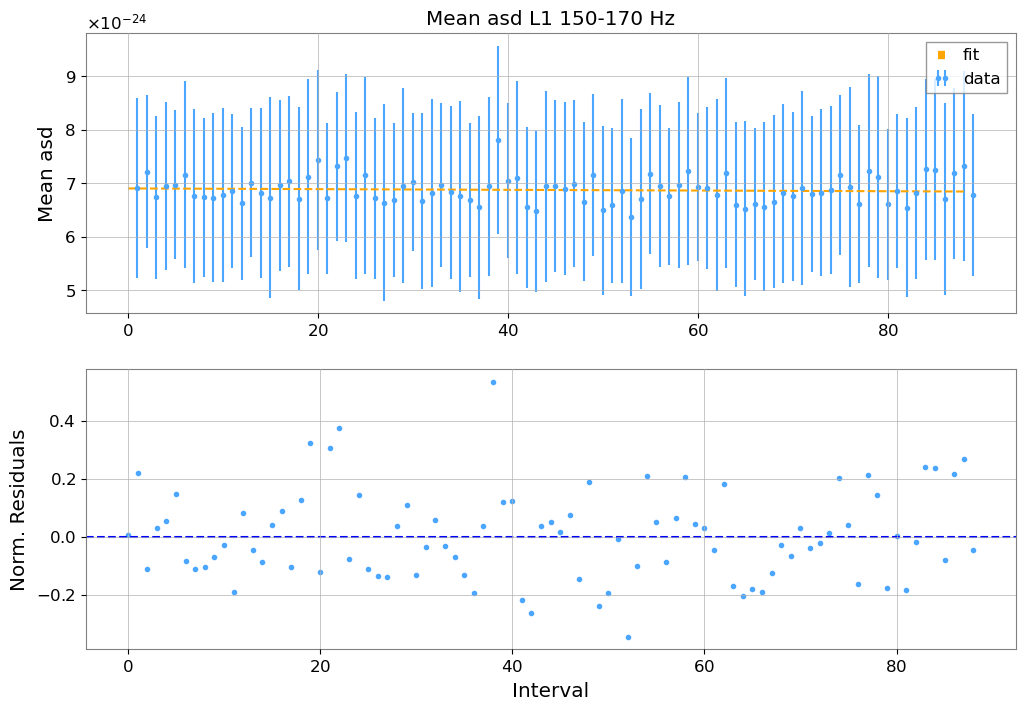

In [57]:
'''mean_plot = Plot(mean_asd_L1, figsize=(12, 4.8), title='ASD mean for detector L1', color=GW_OBSERVATORY_COLORS['L1'])
ax = mean_plot.gca()
ax.set_xlabel('Number of interval selected')
ax.set_ylabel('Mean value [Hz^-1/2]')
std_plot = Plot(std_asd_L1, figsize=(12, 4.8), title='ASD std for detector L1', color=GW_OBSERVATORY_COLORS['L1'])
ax = std_plot.gca()
ax.set_xlabel('Number of interval selected')
ax.set_ylabel('Std value [Hz^-1/2]')'''

# fit
guess = [0, np.mean(mean_asd_L1)]
xarray = np.linspace(1, len(mean_asd_L1), len(mean_asd_L1))

popt, pcov = optimize.curve_fit(line, xarray, mean_asd_L1, sigma=std_asd_L1, p0=guess , absolute_sigma=True)
print("m =", popt[0], "+/-", pcov[0,0]**0.5)
print("q =", popt[1], "+/-", pcov[1,1]**0.5)

plot=plt.figure(figsize=(12, 8))
plt.subplot(2,1,1)
plt.errorbar(xarray, mean_asd_L1, yerr=std_asd_L1, fmt='.', color=GW_OBSERVATORY_COLORS['L1'], label='data')
plt.title('Mean asd L1 150-170 Hz')
plt.ylabel('Mean asd')
plt.plot(xdata, line(xarray, popt[0], popt[1]), color='orange', linestyle='--', label='fit')
plt.legend()

#compute residuals
residuals = (mean_asd_L1 - line(xarray, popt[0], popt[1]))/std_asd_L1

#plot
plt.subplot(2,1,2)
plt.plot(xdata, residuals, '.', color=GW_OBSERVATORY_COLORS['L1'])
plt.xlabel("Interval")
plt.ylabel("Norm. Residuals")

#draw line around zero
plt.axhline(0, color="b", linestyle='--')

# chi squared
chisqr = sum((mean_asd_L1 - line(xarray, popt[0], popt[1]))**2 / np.array(std_asd_L1)**2)
dof = len(mean_asd_L1) - len(popt)
chisqr_red = chisqr/dof
print(f'Reduced chi^2 = {chisqr_red}')



my_file= 'asdmean_L1.pdf'
#plot.savefig(os.path.join(results_dir, my_file))

### Noise characterization V1

In [53]:
ev_t0_min = ev_gps-60*20 # 20 mins before event
ev_t0_max = ev_gps+60*10 # 10 mins after event
ev_ifo = 'V1'
ev_gps = event_gps(ev_name)
ev_t0_min = ev_gps-60*20 # 20 mins before event
ev_t0_max = ev_gps+60*10 # 10 mins after event
#data = TimeSeries.fetch_open_data(ev_ifo,ev_t0_min,ev_t0_max,cache=True)
#plot_data=Plot(data, color=colors[index], figsize=(12, 4.8), title='Time series for detector %s' % ii, separate=True)
time_range = np.arange(ev_t0_min, ev_t0_max, 20) # start, stop, step

mean_asd_V1 = [] # creating array for asd mean 
std_asd_V1 = [] # creating array for asd std

for ii in range(len(time_range)-1): # falli a blocchi di 5 se no esplode
    data = TimeSeries.fetch_open_data(ev_ifo, time_range[ii] , time_range[ii+1] ,cache=True) # time range
    #plot_data=Plot(data, figsize=(12, 4.8), title='Time series for detector V1', color=GW_OBSERVATORY_COLORS['V1']) # plot time series
    fft_data = data.fft() # compute fft
    window = get_window('hann', data[ii:ii+1].size)
    hwin = data * window
    fftamp = hwin.fft().abs()
    
    
    asd = data.asd(fftlength=4, method="median") # plot asd
    #plot = asd.plot(color=GW_OBSERVATORY_COLORS['V1'])
    #ax = plot.gca()
    #ax.set_xlim(10, 1400)
    #ax.set_ylim(2e-24, 1e-20)
    #ax.set_title(ev_ifo+ " asd for "+ev_name)
    #ax.axvline(f_start[0], linestyle='--', color=GW_OBSERVATORY_COLORS['V1'])
    #ax.axvline(f_stop[0], linestyle='--', color=GW_OBSERVATORY_COLORS['V1'])
    mean = np.mean(asd[start_asd[2]:stop_asd[2]])
    mean_asd_V1.append(mean.value) # .value function returns only the number without the unit
    std = np.std(asd[start_asd[2]:stop_asd[2]])
    std_asd_V1.append(std.value)
    #print('calculating %d' %ii)
print('Done')
    #plot.refresh
plot.show()
#print(mean_asd_V1)
#print(std_asd_V1)



/opt/conda/lib/python3.8/site-packages/gwpy/types/series.py:924: UserWarning: TimeSeries.crop given end larger than current end, crop will end when the Series actually ends.
  warn('%s.crop given end larger than current end, '


Done


m = 1.622787589911839e-27 +/- 1.714130546423053e-26
q = 1.6932343412657627e-23 +/- 8.935803580761493e-25
Reduced chi^2 = 0.023312791559985425


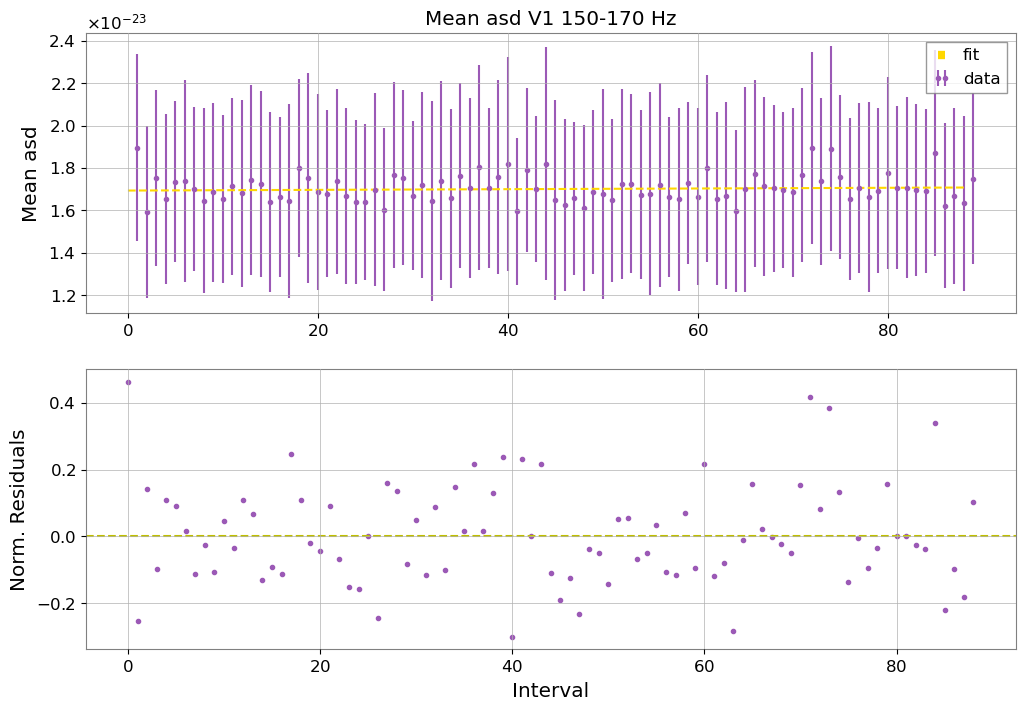

In [55]:
'''mean_plot = Plot(mean_asd_V1, figsize=(12, 4.8), title='ASD mean for detector V1', color=GW_OBSERVATORY_COLORS['V1'])
ax = mean_plot.gca()
ax.set_xlabel('Number of interval selected')
ax.set_ylabel('Mean value [Hz^-1/2]')
std_plot = Plot(std_asd_V1, figsize=(12, 4.8), title='ASD std for detector V1', color=GW_OBSERVATORY_COLORS['V1'])
ax = std_plot.gca()
ax.set_xlabel('Number of interval selected')
ax.set_ylabel('Std value [Hz^-1/2]')'''
# fit
guess = [0, np.mean(mean_asd_V1)]
xarray = np.linspace(1, len(mean_asd_V1), len(mean_asd_V1))

popt, pcov = optimize.curve_fit(line, xarray, mean_asd_V1, sigma=std_asd_V1, p0=guess , absolute_sigma=True)
print("m =", popt[0], "+/-", pcov[0,0]**0.5)
print("q =", popt[1], "+/-", pcov[1,1]**0.5)

plot=plt.figure(figsize=(12, 8))
plt.subplot(2,1,1)
plt.errorbar(xarray, mean_asd_V1, yerr=std_asd_V1, fmt='.', color=GW_OBSERVATORY_COLORS['V1'], label='data')
plt.title('Mean asd V1 150-170 Hz')
plt.ylabel('Mean asd')
plt.plot(xdata, line(xarray, popt[0], popt[1]), color='gold', linestyle='--', label='fit')
plt.legend()

#compute residuals
residuals = (mean_asd_V1 - line(xarray, popt[0], popt[1]))/std_asd_V1

#plot
plt.subplot(2,1,2)
plt.plot(xdata, residuals, '.', color=GW_OBSERVATORY_COLORS['V1'])
plt.xlabel("Interval")
plt.ylabel("Norm. Residuals")

#draw line around zero
plt.axhline(0, color="y", linestyle='--')

# chi squared
chisqr = sum((mean_asd_V1 - line(xarray, popt[0], popt[1]))**2 / np.array(std_asd_V1)**2)
dof = len(mean_asd_V1) - len(popt)
chisqr_red = chisqr/dof
print(f'Reduced chi^2 = {chisqr_red}')



my_file= 'asdmean_V1.pdf'
plot.savefig(os.path.join(results_dir, my_file))

### Quick look time domain analysis

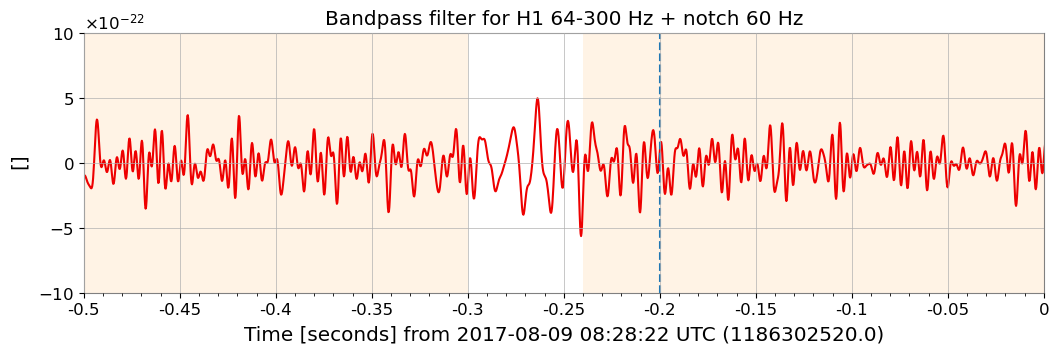

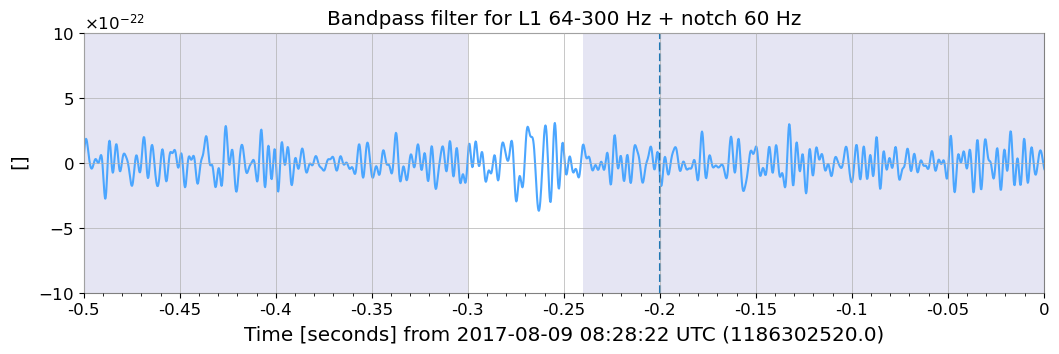

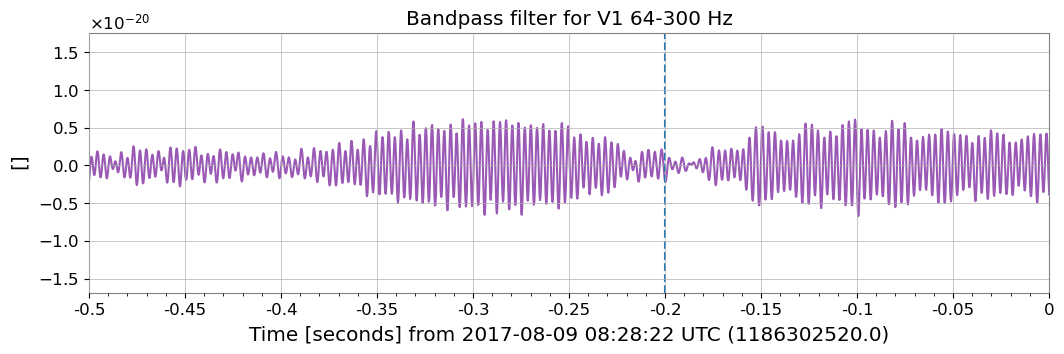

In [10]:
# Applying a passband filter (64-300 Hz)

' DETECTOR H1'

data_filtered=data_H1.bandpass(64,300).notch(60) # notch filter to remove 60 Hz noise

plot = data_filtered.plot(color=GW_OBSERVATORY_COLORS['H1'])
ax = plot.gca()
#zoom around the event. Can we see something now?
ax.set_xlim(ev_gps-0.3,ev_gps+0.2)
ax.set_ylim(-1e-21,1e-21)
ax.set_title('Bandpass filter for H1 64-300 Hz + notch 60 Hz')
ax.axvline(ev_gps, linestyle='--')
ax.axvspan(ev_gps-0.3, ev_gps-0.1, facecolor='darkorange', alpha=0.1)
ax.axvspan(ev_gps-0.04, ev_gps+0.2, facecolor='darkorange', alpha=0.1)
plot.refresh()
plot.savefig(os.path.join(results_dir, 'filter_H1.pdf'))


' DETECTOR L1'

data_filtered=data_L1.bandpass(64,300).notch(60) # notch filter to remove 60 Hz noise

plot = data_filtered.plot(color=GW_OBSERVATORY_COLORS['L1'])
ax = plot.gca()
#zoom around the event. Can we see something now?
ax.set_xlim(ev_gps-0.3,ev_gps+0.2)
ax.set_ylim(-1e-21,1e-21)
ax.set_title('Bandpass filter for L1 64-300 Hz + notch 60 Hz')
ax.axvline(ev_gps, linestyle='--')
ax.axvspan(ev_gps-0.3, ev_gps-0.1, facecolor='darkblue', alpha=0.1)
ax.axvspan(ev_gps-0.04, ev_gps+0.2, facecolor='darkblue', alpha=0.1)
plot.refresh()
plot.savefig(os.path.join(results_dir, 'filter_L1.pdf'))

' DETECTOR V1'

data_filtered=data_V1.bandpass(64,300)

plot = data_filtered.plot(color=GW_OBSERVATORY_COLORS['V1'])
ax = plot.gca()
#zoom around the event. Can we see something now?
ax.set_xlim(ev_gps-0.3,ev_gps+0.2)
#ax.set_ylim(-2e-21,2e-21)
ax.set_title('Bandpass filter for V1 64-300 Hz')
ax.axvline(ev_gps, linestyle='--')
plot.refresh()
plot.savefig(os.path.join(results_dir, 'filter_V1.pdf'))

### Signal search with template matching H1

In [97]:
# downsampling at 2048 Hz

# Select a shorter time of 2 seconds around the event
dt_win=10
ev_t0_min = ev_gps-dt_win
ev_t0_max = ev_gps+dt_win

ev_ifo = 'H1'

print("Get data for %s (%s) GPS: %.2f - %.2f" % (ev_name,ev_ifo,ev_t0_min,ev_t0_max))
    
#fetch the data. Use cache=True to keep the data in the cache memory (to speed things up)
data = TimeSeries.fetch_open_data(ev_ifo,ev_t0_min,ev_t0_max,cache=True)

#get the segments in a larger time window (just to have a bigger time span to look over)
segments = DataQualityFlag.fetch_open_data(ev_ifo+"_DATA",ev_t0_min-dt_win,ev_t0_max+dt_win)
print("Done")

Get data for GW170809 (H1) GPS: 1186302509.80 - 1186302529.80
Done


/opt/conda/lib/python3.8/site-packages/gwpy/types/series.py:924: UserWarning: TimeSeries.crop given end larger than current end, crop will end when the Series actually ends.
  warn('%s.crop given end larger than current end, '


In [98]:

# Convert the data from gwpy to pyCBC format
strain = data.to_pycbc()

# Remove the frequencies below 15 Hz and downsample the data to 2048Hz, we can do this because higher frequencies are not important
strain = highpass(strain, 15.0)
strain = resample_to_delta_t(strain, 1.0/2048)

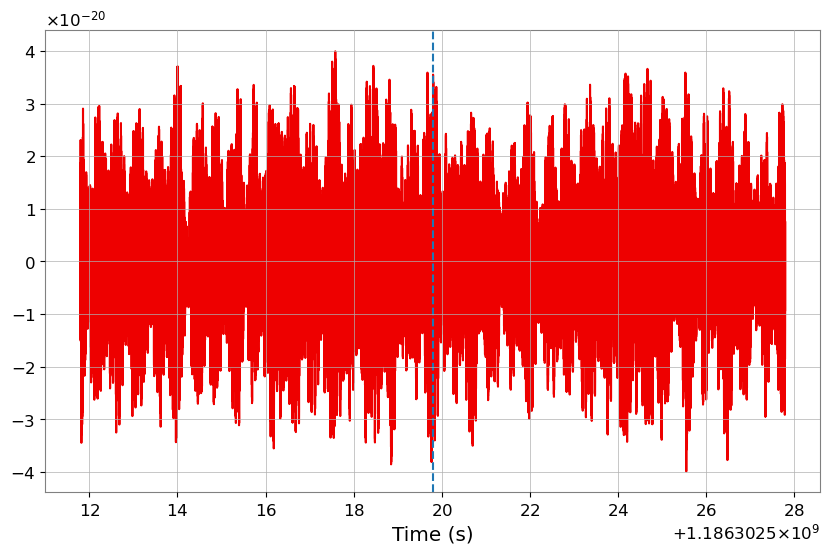

In [99]:
# Remove 2 seconds of data from both the beginning and end, to remove the ringing artifacts
conditioned = strain.crop(2, 2)

plot = pylab.figure(figsize=(10, 6))
pylab.plot(conditioned.sample_times, conditioned, color=GW_OBSERVATORY_COLORS['H1'])
pylab.xlabel('Time (s)')
ax = plot.gca()
ax.axvline(ev_gps, linestyle='--')
pylab.show()

In [100]:
#We can calculate the ASD and PSD also with pyCBC



# Estimate the power spectral density

# We use 4 second samples of our time series in Welch method.
psd = conditioned.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner
psd = interpolate(psd, conditioned.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to inform the function to not include frequencies
# below this frequency. 
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)

In [102]:
' Building a template'

# In this case we "know" what the signal parameters are. In a search
# we would grid over the parameters and calculate the SNR time series
# for each one

m_guess = 30 # Solar masses
m_test = np.arange(25, 35.5, 0.5)

conditioned = strain.crop(2, 2)


det_times=[]
det_snr=[]

index_ii=[]
index_jj=[]

for ii in range(len(m_test) - 1):
    jj = ii  # Reset jj to ii at the start of each ii loop
    while jj < len(m_test):
        
# The output of this function are the "plus" and "cross" polarizations of the gravitational-wave signal 
# as viewed from the line of sight at a given source inclination (assumed face-on if not provided)
        hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                                 mass1=m_test[ii],
                                 mass2=m_test[jj],
                                 delta_t=conditioned.delta_t,
                                 f_lower=20)
        
        # We will resize the vector to match our data
        hp.resize(len(conditioned))

        template = hp.cyclic_time_shift(hp.start_time)
        
        snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)


        snr = snr.crop(4 + 3.6, 4)


        peak = abs(snr).numpy().argmax()
        snrp = snr[peak]
        det_snr.append(snrp)
        time = snr.sample_times[peak]
        det_times.append(time)
        index_ii.append(ii) # per trovare le masse corrispondenti
        index_jj.append(jj) # per trovare le masse corrispondenti

        jj += 1

det_times=np.array(det_times) 
det_snr=np.array(det_snr)
index2=np.where(det_times<1186302520)
print(index2)
selected_times = det_times[index2]
selected_snr = det_snr[index2]
index=np.where(det_snr==max(selected_snr))[0]
print("Best masses are %.1f and %.1f" % (m_test[index_ii[index[0]]], m_test[index_jj[index[0]]]))
print("We found a signal at {}s with SNR {}".format(det_times[index[0]], 
                                                    abs(det_snr[index[0]])))

(array([  0,   1,   2, ..., 227, 228, 229]),)
Best masses are 28.0 and 33.0
We found a signal at 1186302519.7519531s with SNR 6.4438580340932194


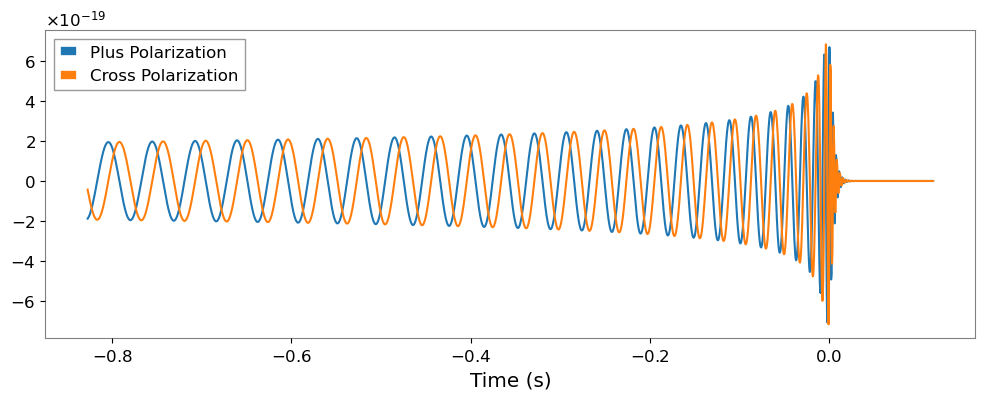

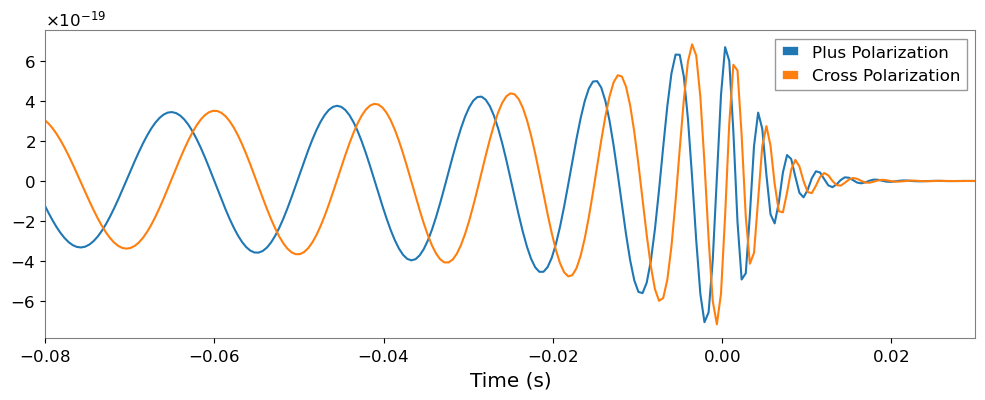

(15.0, 17.0)

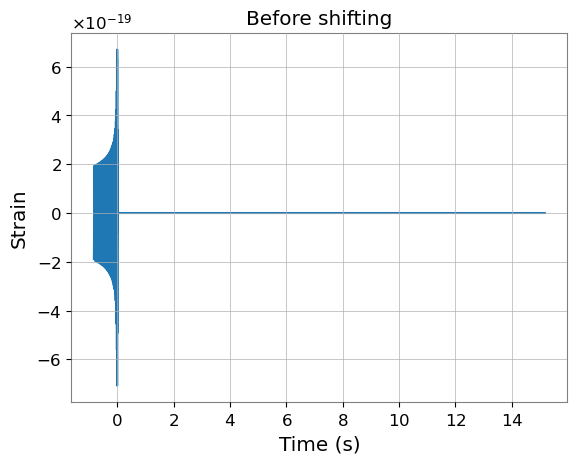

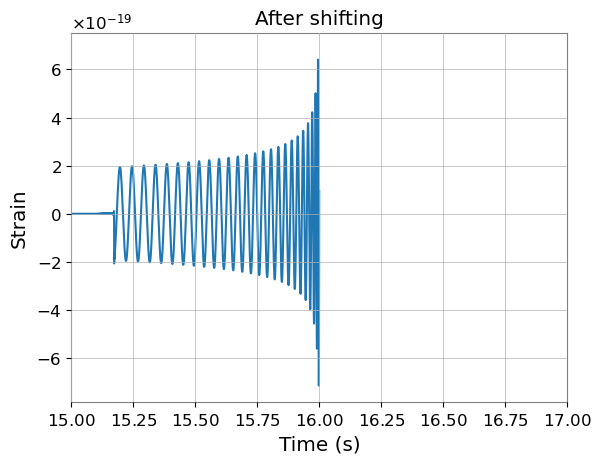

In [103]:
from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

' Once found the best masses to the same thing with those'
conditioned = strain.crop(2, 2)
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                            mass1=28,
                            mass2=33,
                            delta_t=conditioned.delta_t,
                            f_lower=20)

plot=plt.figure(figsize=(12,4))
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.legend()
pylab.grid()
pylab.show()
plot.savefig(os.path.join(results_dir, 'polarizations.pdf'))

# Zoom in near the merger time#
plot=plt.figure(figsize=(12,4))
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.xlim(-.08, .03)
pylab.legend()
pylab.grid()
pylab.show()
plot.savefig(os.path.join(results_dir, 'polarizations_zoom.pdf'))
        
# We will resize the vector to match our data
hp.resize(len(conditioned))

pylab.figure()
pylab.title('Before shifting')
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

template = hp.cyclic_time_shift(hp.start_time)

pylab.figure()
pylab.title('After shifting')
pylab.plot(template.sample_times, template)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.xlim([15,17])

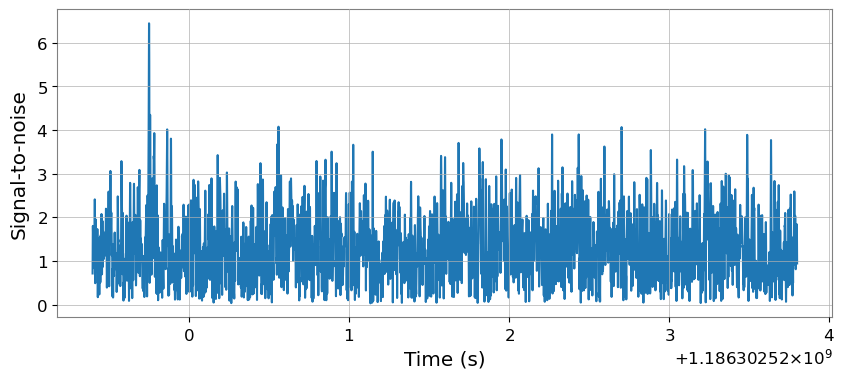

In [104]:
snr = matched_filter(template, conditioned,
                psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 3.6, 4)

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

In [105]:
# Shift the template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)
# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0)
# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time


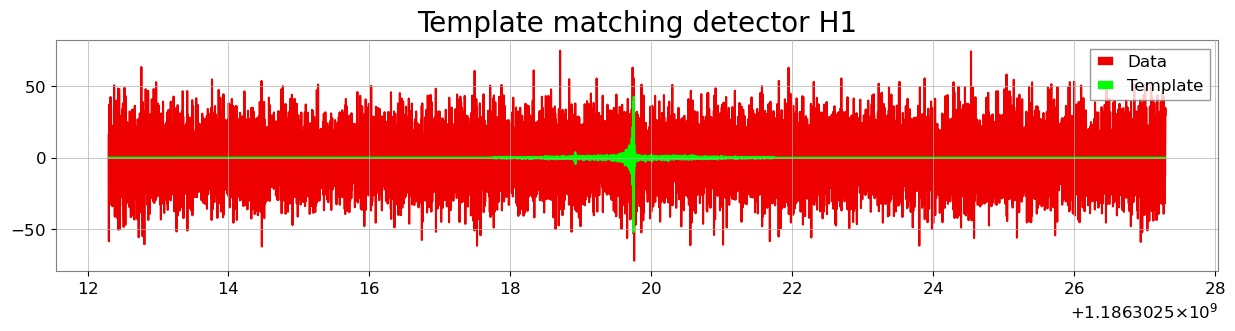

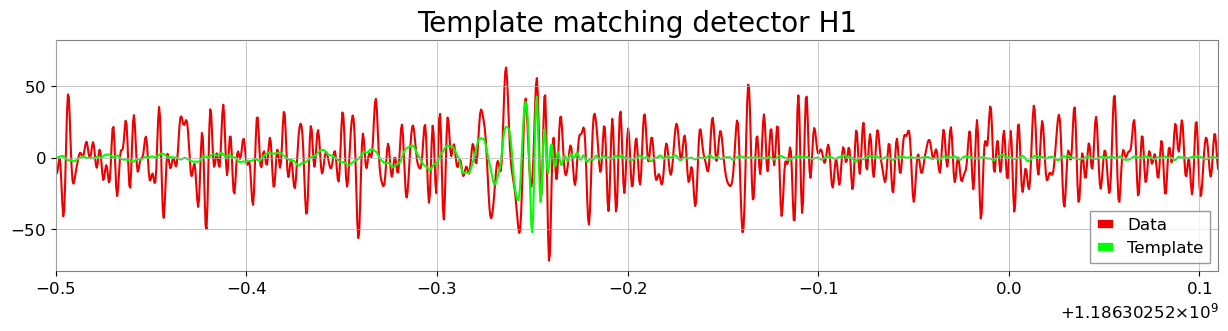

In [107]:
# We do it this way so that we can whiten (i.e. normalize the signal to the PSD) both the template and the data
white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries() # fft per andare nel dominio delle frequenze e poi divido per la ASD
white_template = (aligned.to_frequencyseries() / psd**0.5).to_timeseries()
white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)
# Select the time around the merger
#white_data = white_data.time_slice(ev_gps-.2, ev_gps+.1)
#print(white_data)
#white_template = white_template.time_slice(ev_gps-.2, ev_gps+.1)
plot=pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data", color=GW_OBSERVATORY_COLORS['H1'])
pylab.plot(white_template.sample_times, white_template, label="Template", color='#00FF00')
pylab.legend()
pylab.title('Template matching detector H1', fontsize=20)
ax = plot.gca()
#ax.axvline(ev_gps, linestyle='--', color='orange')
pylab.show()
plot.savefig(os.path.join(results_dir, 'final_H1.pdf'), bbox_inches='tight')

plot=pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data", color=GW_OBSERVATORY_COLORS['H1'])
pylab.plot(white_template.sample_times, white_template, label="Template", color='#00FF00')
pylab.legend()
pylab.title('Template matching detector H1', fontsize=20)
ax = plot.gca()
plt.xlim(ev_gps-0.3, ev_gps+0.31)
#ax.axvline(ev_gps, linestyle='--', color='orange')
pylab.show()
plot.savefig(os.path.join(results_dir, 'final_H1_zoom.pdf'), bbox_inches='tight')

### Signal search with template matching L1

In [108]:
# downsampling at 2048 Hz

# Select a shorter time of 2 seconds around the event
dt_win=10
ev_t0_min = ev_gps-dt_win
ev_t0_max = ev_gps+dt_win

ev_ifo = 'L1'

print("Get data for %s (%s) GPS: %.2f - %.2f" % (ev_name,ev_ifo,ev_t0_min,ev_t0_max))
    
#fetch the data. Use cache=True to keep the data in the cache memory (to speed things up)
data = TimeSeries.fetch_open_data(ev_ifo,ev_t0_min,ev_t0_max,cache=True)

#get the segments in a larger time window (just to have a bigger time span to look over)
segments = DataQualityFlag.fetch_open_data(ev_ifo+"_DATA",ev_t0_min-dt_win,ev_t0_max+dt_win)
print("Done")

Get data for GW170809 (L1) GPS: 1186302509.80 - 1186302529.80
Done


/opt/conda/lib/python3.8/site-packages/gwpy/types/series.py:924: UserWarning: TimeSeries.crop given end larger than current end, crop will end when the Series actually ends.
  warn('%s.crop given end larger than current end, '


In [109]:
import pylab
from pycbc.filter import resample_to_delta_t, highpass

# Convert the data from gwpy to pyCBC format
strain = data.to_pycbc()

# Remove the frequencies below 15 Hz and downsample the data to 2048Hz
strain = highpass(strain, 15.0)
strain = resample_to_delta_t(strain, 1.0/2048)

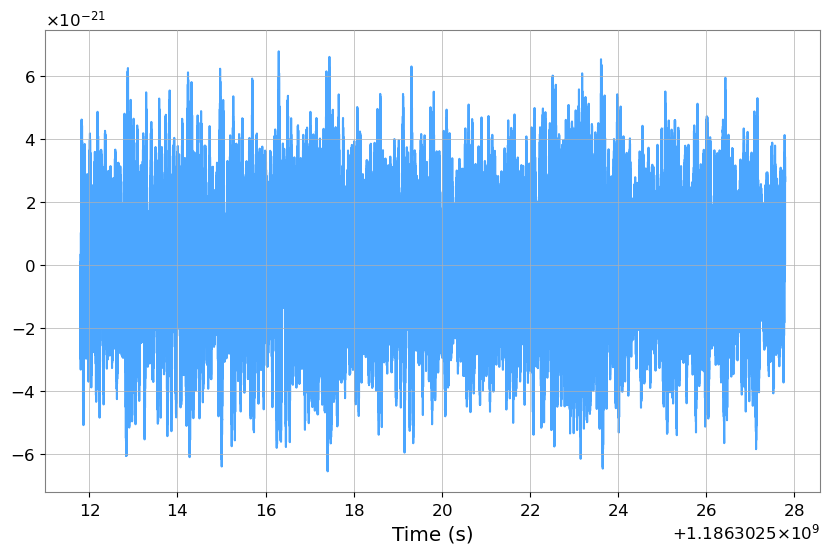

In [110]:
# Remove 2 seconds of data from both the beginning and end, to remove the ringing artifacts
conditioned = strain.crop(2, 2)

pylab.figure(figsize=(10, 6))
pylab.plot(conditioned.sample_times, conditioned, color=GW_OBSERVATORY_COLORS['L1'])
pylab.xlabel('Time (s)')
pylab.show()

In [111]:
#We can calculate the ASD and PSD also with pyCBC

from pycbc.psd import interpolate, inverse_spectrum_truncation

# Estimate the power spectral density

# We use 4 second samples of our time series in Welch method.
psd = conditioned.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner
psd = interpolate(psd, conditioned.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to inform the function to not include frequencies
# below this frequency. 
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)

In [112]:
' Building a template'

# In this case we "know" what the signal parameters are. In a search
# we would grid over the parameters and calculate the SNR time series
# for each one

m_guess = 30 # Solar masses
m_test = np.arange(25, 35.5, 0.5)

conditioned = strain.crop(2, 2)


det_times=[]
det_snr=[]

index_ii=[]
index_jj=[]

for ii in range(len(m_test) - 1):
    jj = ii  # Reset jj to ii at the start of each ii loop
    while jj < len(m_test):
        hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                                 mass1=m_test[ii],
                                 mass2=m_test[jj],
                                 delta_t=conditioned.delta_t,
                                 f_lower=20)
        
        # We will resize the vector to match our data
        hp.resize(len(conditioned))

        template = hp.cyclic_time_shift(hp.start_time)
        
        snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)


        snr = snr.crop(4 + 3.6, 4)


        peak = abs(snr).numpy().argmax()
        snrp = snr[peak]
        det_snr.append(snrp)
        time = snr.sample_times[peak]
        det_times.append(time)
        index_ii.append(ii) # per trovare le masse corrispondenti
        index_jj.append(jj) # per trovare le masse corrispondenti

        jj += 1

det_times=np.array(det_times) 
det_snr=np.array(det_snr)
index2=np.where(det_times<1186302520)
selected_times = det_times[index2]
selected_snr = det_snr[index2]
index=np.where(det_snr==max(selected_snr))[0]
print("Best masses are %.1f and %.1f" % (m_test[index_ii[index[0]]], m_test[index_jj[index[0]]]))
print("We found a signal at {}s with SNR {}".format(det_times[index[0]], 
                                                    abs(det_snr[index[0]])))

Best masses are 31.0 and 35.0
We found a signal at 1186302519.7426758s with SNR 9.641150939846925


(15.0, 17.0)

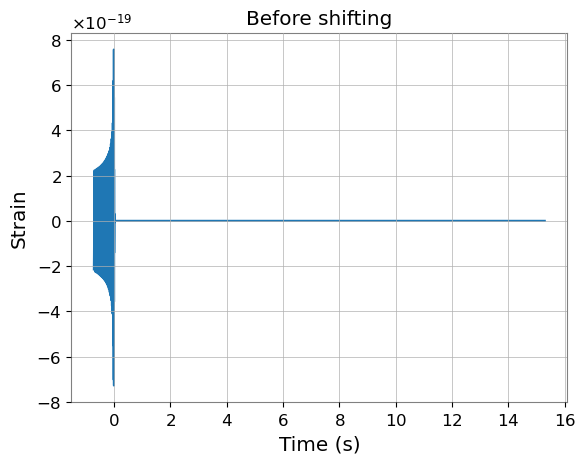

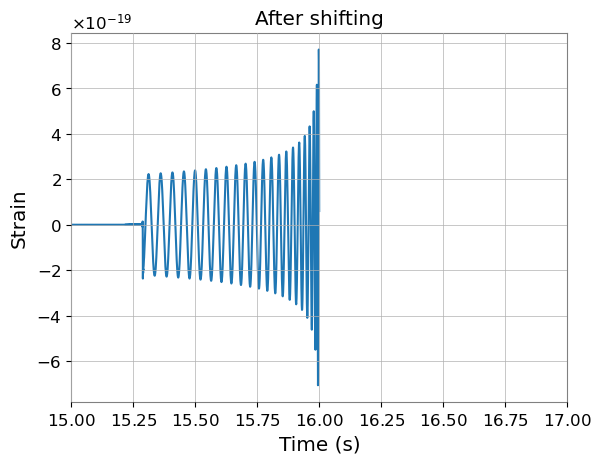

In [113]:
from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

' Once found the best masses to the same thing with those'
conditioned = strain.crop(2, 2)
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                            mass1=31.0,
                            mass2=35.0,
                            delta_t=conditioned.delta_t,
                            f_lower=20)
        
# We will resize the vector to match our data
hp.resize(len(conditioned))

pylab.figure()
pylab.title('Before shifting')
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

template = hp.cyclic_time_shift(hp.start_time)

pylab.figure()
pylab.title('After shifting')
pylab.plot(template.sample_times, template)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.xlim([15,17])

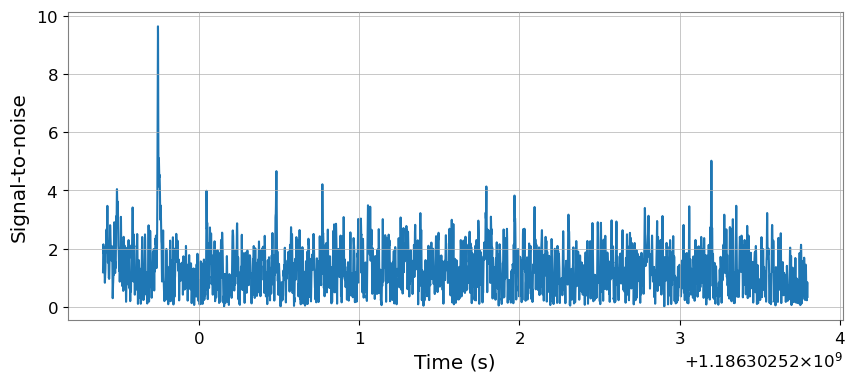

In [114]:
snr = matched_filter(template, conditioned,
                psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 3.6, 4)

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

In [115]:
# Shift the template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)
# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0)
# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time


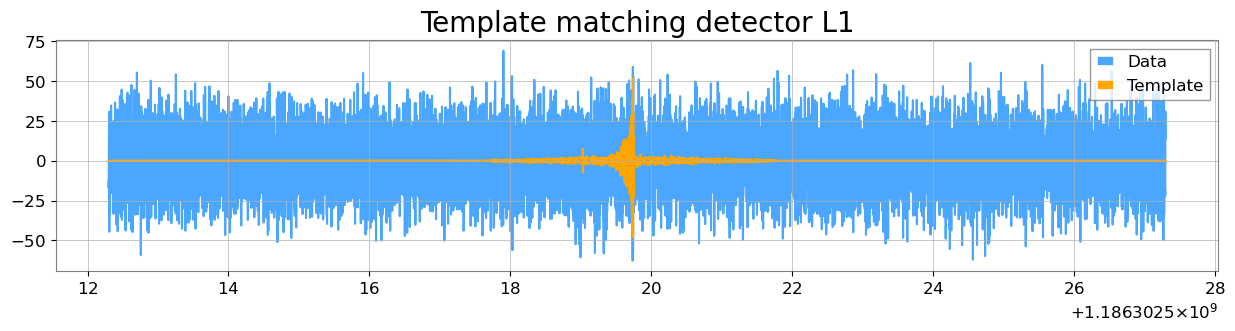

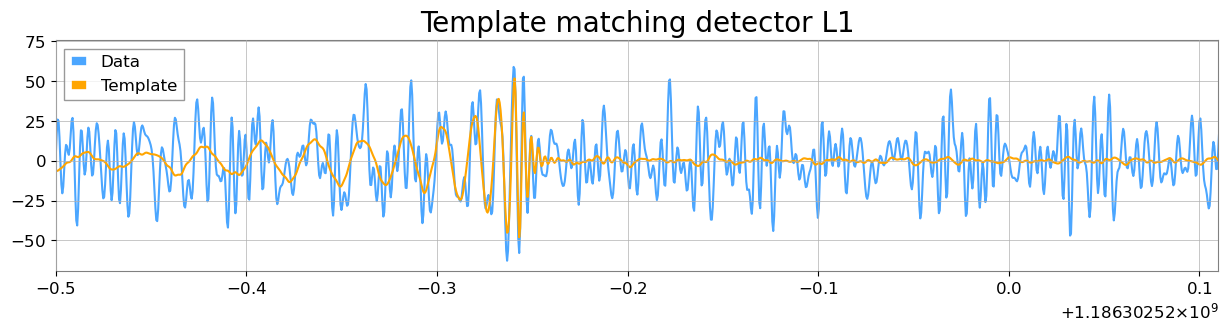

In [117]:
# We do it this way so that we can whiten (i.e. normalize the signal to the PSD) both the template and the data
white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries() # fft per andare nel dominio delle frequenze e poi divido per la ASD
white_template = (aligned.to_frequencyseries() / psd**0.5).to_timeseries()
white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

plot=pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data", color=GW_OBSERVATORY_COLORS['L1'])
pylab.plot(white_template.sample_times, white_template, label="Template", color='orange')
pylab.legend()
pylab.title('Template matching detector L1', fontsize=20)
ax = plot.gca()
plot.savefig(os.path.join(results_dir, 'final_L1.pdf'), bbox_inches='tight')
#ax.axvline(ev_gps, linestyle='--', color='orange')
pylab.show()


plot=pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data", color=GW_OBSERVATORY_COLORS['L1'])
pylab.plot(white_template.sample_times, white_template, label="Template", color='orange')
pylab.legend()
pylab.title('Template matching detector L1', fontsize=20)
ax = plot.gca()
plt.xlim(ev_gps-0.3, ev_gps+0.31)
plot.savefig(os.path.join(results_dir, 'final_L1_zoom.pdf'), bbox_inches='tight')
#ax.axvline(ev_gps, linestyle='--', color='orange')
pylab.show()

### Signal search with template matching V1

In [12]:
# downsampling at 2048 Hz

# Select a shorter time of 2 seconds around the event
dt_win=10
ev_t0_min = ev_gps-dt_win
ev_t0_max = ev_gps+dt_win

ev_ifo = 'V1'

print("Get data for %s (%s) GPS: %.2f - %.2f" % (ev_name,ev_ifo,ev_t0_min,ev_t0_max))
    
#fetch the data. Use cache=True to keep the data in the cache memory (to speed things up)
data = TimeSeries.fetch_open_data(ev_ifo,ev_t0_min,ev_t0_max,cache=True)

#get the segments in a larger time window (just to have a bigger time span to look over)
segments = DataQualityFlag.fetch_open_data(ev_ifo+"_DATA",ev_t0_min-dt_win,ev_t0_max+dt_win)
print("Done")

Get data for GW170809 (V1) GPS: 1186302509.80 - 1186302529.80


/opt/conda/lib/python3.8/site-packages/gwpy/types/series.py:924: UserWarning: TimeSeries.crop given end larger than current end, crop will end when the Series actually ends.
  warn('%s.crop given end larger than current end, '


Done


In [13]:
import pylab
from pycbc.filter import resample_to_delta_t, highpass

# Convert the data from gwpy to pyCBC format
strain = data.to_pycbc()

# Remove the frequencies below 15 Hz and downsample the data to 2048Hz
strain = highpass(strain, 15.0)
strain = resample_to_delta_t(strain, 1.0/2048)

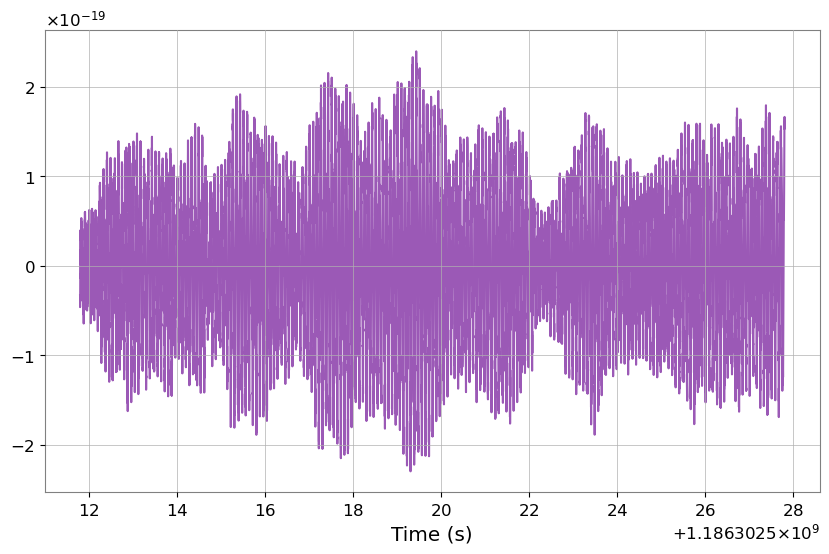

In [14]:
# Remove 2 seconds of data from both the beginning and end, to remove the ringing artifacts
conditioned = strain.crop(2, 2)

pylab.figure(figsize=(10, 6))
pylab.plot(conditioned.sample_times, conditioned, color=GW_OBSERVATORY_COLORS['V1'])
pylab.xlabel('Time (s)')
pylab.show()

In [15]:
#We can calculate the ASD and PSD also with pyCBC

from pycbc.psd import interpolate, inverse_spectrum_truncation

# Estimate the power spectral density

# We use 4 second samples of our time series in Welch method.
psd = conditioned.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner
psd = interpolate(psd, conditioned.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to inform the function to not include frequencies
# below this frequency. 
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)

In [21]:
' Building a template'

# In this case we "know" what the signal parameters are. In a search
# we would grid over the parameters and calculate the SNR time series
# for each one

m_guess = 30 # Solar masses
m_test = np.arange(25, 35.5, 0.5)

conditioned = strain.crop(2, 2)


det_times=[]
det_snr=[]

index_ii=[]
index_jj=[]

for ii in range(len(m_test) - 1):
    jj = ii  # Reset jj to ii at the start of each ii loop
    while jj < len(m_test):
        hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                                 mass1=m_test[ii],
                                 mass2=m_test[jj],
                                 delta_t=conditioned.delta_t,
                                 f_lower=20)
        
        # We will resize the vector to match our data
        hp.resize(len(conditioned))

        template = hp.cyclic_time_shift(hp.start_time)
        
        snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)


        snr = snr.crop(4 + 3.6, 4)


        peak = abs(snr).numpy().argmax()
        snrp = snr[peak]
        det_snr.append(snrp)
        time = snr.sample_times[peak]
        det_times.append(time)
        index_ii.append(ii) # per trovare le masse corrispondenti
        index_jj.append(jj) # per trovare le masse corrispondenti

        jj += 1

det_times=np.array(det_times) 
det_snr=np.array(det_snr)
index2=np.where(det_times<1186302519.9)
selected_times = det_times[index2]
selected_snr = det_snr[index2]
index=np.where(det_snr==max(selected_snr))[0]
print("Best masses are %.1f and %.1f" % (m_test[index_ii[index[0]]], m_test[index_jj[index[0]]]))
print("We found a signal at {}s with SNR {}".format(det_times[index[0]], 
                                                    abs(det_snr[index[0]])))

Best masses are 27.0 and 33.0
We found a signal at 1186302519.890625s with SNR 4.346786851716367


(15.0, 17.0)

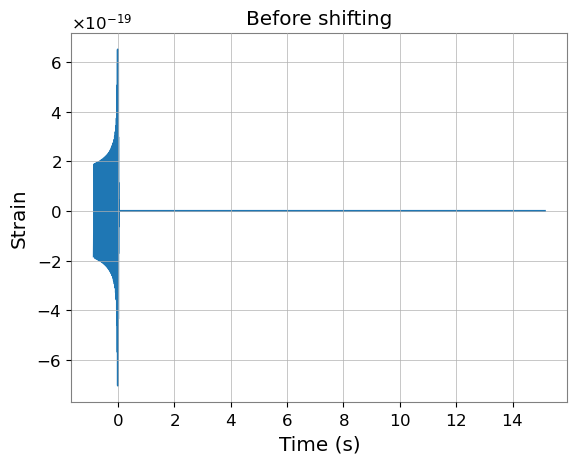

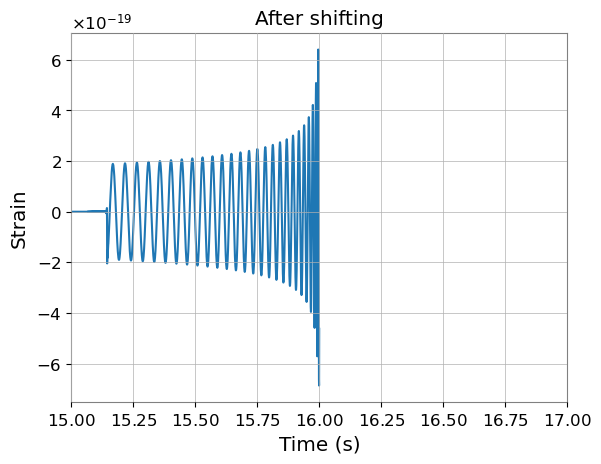

In [123]:
from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

' Once found the best masses to the same thing with those'
conditioned = strain.crop(2, 2)
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                            mass1=27,
                            mass2=33,
                            delta_t=conditioned.delta_t,
                            f_lower=20)
        
# We will resize the vector to match our data
hp.resize(len(conditioned))

pylab.figure()
pylab.title('Before shifting')
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

template = hp.cyclic_time_shift(hp.start_time)

pylab.figure()
pylab.title('After shifting')
pylab.plot(template.sample_times, template)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.xlim([15,17])

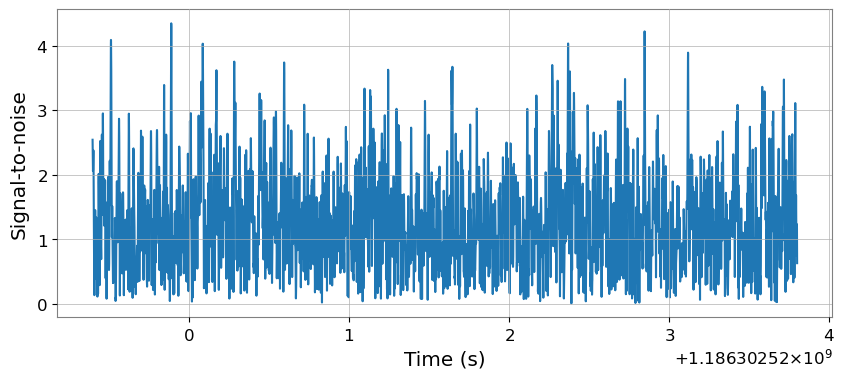

In [124]:
snr = matched_filter(template, conditioned,
                psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 3.6, 4)

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

In [125]:
# Shift the template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)
# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0)
# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time


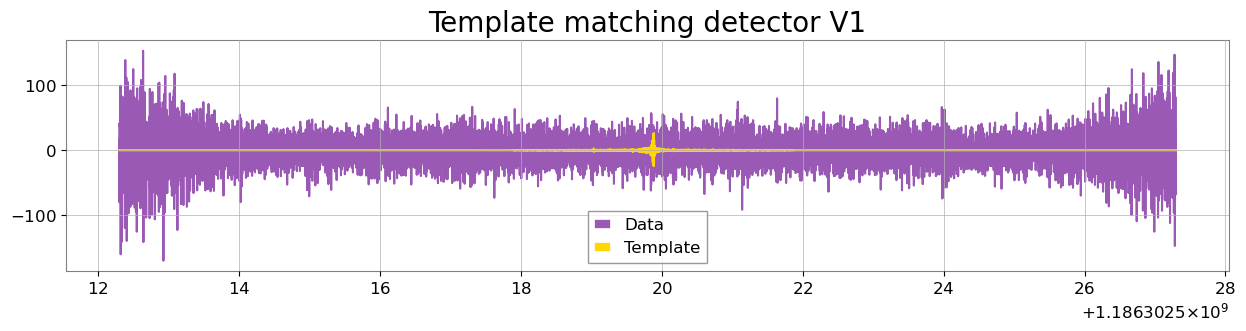

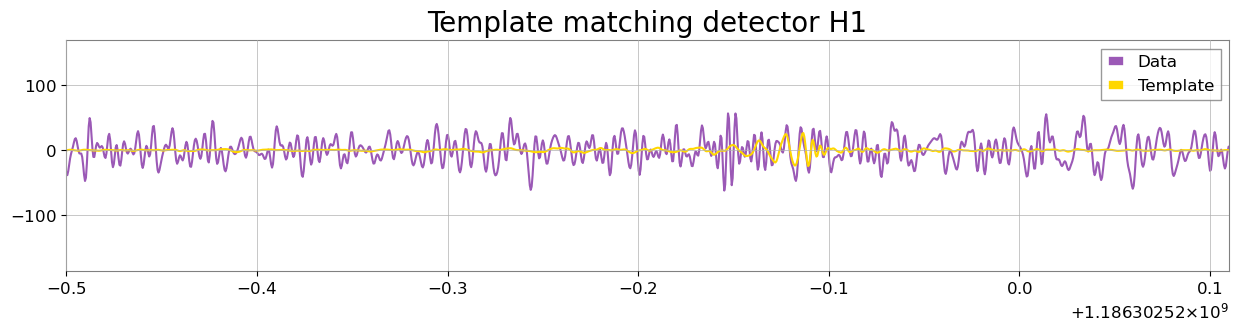

In [126]:
# We do it this way so that we can whiten (i.e. normalize the signal to the PSD) both the template and the data
white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries()
white_template = (aligned.to_frequencyseries() / psd**0.5).to_timeseries()
white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)
# Select the time around the merger
#white_data = white_data.time_slice(ev_gps-.2, ev_gps+.1)
#print(white_data)
#white_template = white_template.time_slice(ev_gps-.2, ev_gps+.1)
plot=pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data", color=GW_OBSERVATORY_COLORS['V1'])
pylab.plot(white_template.sample_times, white_template, label="Template", color='gold')
pylab.legend()
pylab.title('Template matching detector V1', fontsize=20)
ax = plot.gca()
plot.savefig(os.path.join(results_dir, 'final_V1.pdf'), bbox_inches='tight')
#ax.axvline(ev_gps, linestyle='--', color='orange')
pylab.show()


plot=pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data", color=GW_OBSERVATORY_COLORS['V1'])
pylab.plot(white_template.sample_times, white_template, label="Template", color='gold')
pylab.legend()
pylab.title('Template matching detector H1', fontsize=20)
ax = plot.gca()
plt.xlim(ev_gps-0.3, ev_gps+0.31)
plot.savefig(os.path.join(results_dir, 'final_V1_zoom.pdf'), bbox_inches='tight')
#ax.axvline(ev_gps, linestyle='--', color='orange')
pylab.show()